# Урок 4. Алгоритм построения дерева решений

## Деревья решений

В этом уроке пойдет речь еще об одном популярном методе машинного обучения - _деревьях решений_. Это семейство алгоритмов значительно отличается от линейных моделей, но применяется также в задачах классификации и регрессии.

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

1. Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

2. Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

3. Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

<img src="data/L4_graphviz.png" width="800">

In [1]:
# визуализировать дерево можно с помощью библиотеки python-graphviz
from graphviz import Digraph

In [2]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

print(dot.source)  

digraph {
	node [shape=box]
	A [label="Клиент старше 18 лет?"]
	B [label="Превышает ли его заработок 50 тысяч рублей?"]
	C [label="Отказать"]
	D [label="Были ли у клиента просроченные кредиты ранее?"]
	E [label="Отказать"]
	F [label="Отказать"]
	G [label="Выдать"]
	A -> B [label="да"]
	A -> C [label="нет"]
	B -> D [label="да"]
	B -> E [label="нет"]
	D -> F [label="да"]
	D -> G [label="нет"]
}


In [3]:
dot

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

В задачах машинного обучения чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы. 

## Построение деревьев решений

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

В машинном обучении деревья строятся последовательно от корня к листьям (так называемый "жадный" способ). Вначале выбирается корень и критерий, по которому выборка разбивается на две. Затем то же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. Задача состоит в выборе способа **разбиения каждого из узлов**, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.

Разбиение выбирается с точки зрения некоторого заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. **Параметры $j$ и $t$ можно выбирать перебором:** признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.

В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.

В задаче классификации это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать вероятности классов

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$

В случае регрессии можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### Критерий информативности

В случае регрессии разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче классификации есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Прирост информации есть утрата неопределенности (=уменьшение энтропии). Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$ 

### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

### Обрезка деревьев

В случае применения метода стрижки (обрезки, прунинга) деревьев использовать критерии останова необязательно, и можно строить переобученные деревья, затем снижая их сложность, удаляя листья по некоторому критерию (например, пока улучшается качество на отложенной выборке). Считается, что стрижка работает лучше, чем критерии останова.

Одним из методов стрижки является _cost-complexity pruning_. Допустим, мы построили дерево, обозначенное как $T_{0}$. В каждом из листьев находятся объекты одного класса, и значение функционала ошибки $R(T)$ при этом будет минимально на $T_{0}$. Для борьбы с переобучением к нему добавляют "штраф" за размер дерева (аналогично регуляризации, рассмотренной нами в предыдущих уроках) и получают новый функционал $R_{\alpha}(T)$:

$$R_{\alpha}(T) = R(T) + \alpha|T|,$$

где $|T|$ - число листьев в дереве, $\alpha$ - некоторый параметр регуляризации. Таким образом если при построении дерева на каком-то этапе построения алгоритма ошибка будет неизменна, а глубина дерева увеличиваться, итоговый функционал, состоящий из их суммы, будет расти.

Однако стрижка деревьев обладает существенными минусами. В частности, она является очень трудоемкой процедурой. Например, она может требовать вычисления функционала качества на валидационной выборке на каждом шаге. К тому же, на данный момент одиночные деревья на практике почти не используются, а используются композиции деревьев, и в этом случае стрижка как метод борьбы с переобучением становится еще более сложным подходом. Обычно в такой ситуации достаточно использовать простые критерии останова.

## CART

CART (Classification and regression trees) - первый из алгоритмов, состоящий в обычном последовательном построении дерева решений и придуманный в 1983 году. На первой итерации строятся все возможные разбиения исходного пространства на два и выбирается такое, при котором максимально выделен один из классов в одно подпространство. На следующих итерациях выбирается худший лист (с наибольшим разнообразием классов), и на нем проводится та же операция. Так продложается до достижения одного из критериев останова. 

Полученное дерево будет подогнано под обучающую выборку (переобучено), так что затем требуется его кросс-валидация или обрезка методом cost-complexity pruning. 

В качестве функции оценки качества разбиения используется критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [5]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

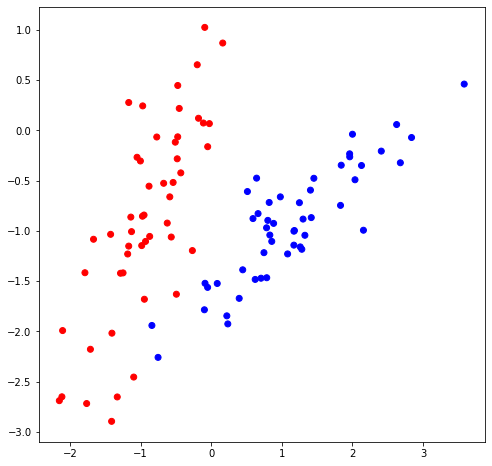

In [6]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        
        #prediction = max(classes, key=classes.get)
        
        # заменил механизм предсказания на взятие среднего значения
        prediction = np.mean(list(classes.values()))
        
        return prediction

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    
    
    # Вместо значения критерия возвращаю несмещенную дисперсию
    var = np.var(list(classes.values()),ddof=1)    
    #print(f'Дисперсия: {np.var(list(classes.values()),ddof=1) }')
    
    
    return var #impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])     

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

#добавил depth
def split(data, labels, index, t, depth):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    
    #добавил счетчик
    depth += 1
    
    return true_data, false_data, true_labels, false_labels, depth

In [12]:
# Нахождение наилучшего разбиения

#добавил depth
def find_best_split(data, labels, depth):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels, depth = split(data, labels, index, t, depth) #учитываю depth
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index, depth

In [13]:
# Построение дерева с помощью рекурсивной функции

#добавил depth и max_depth
def build_tree(data, labels, max_depth, depth):    
    
    quality, t, index, depth = find_best_split(data, labels, depth)
   # print(quality, t, index)



 # поставил ограничение на глубину
    if depth >= max_depth:
        print("Ограничение глубины")
        return Leaf(data, labels)

    
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества    
    if quality == 0:
#         print('leaf')
        print(f"tree_depth_qua = {depth}")
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels, depth = split(data, labels, index, t, depth)
   # print(f"tree_depth = {depth}")
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, depth)
    false_branch = build_tree(false_data, false_labels, max_depth, depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [17]:
# Построим дерево по обучающей выборке

#добавил предельную глубину и начальную глубину
max_depth_limit = 220
depth_start = 0

my_tree = build_tree(train_data, train_labels, max_depth_limit, depth_start)


tree_depth_qua = 140


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
train_labels

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1])

In [19]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Прогноз: 35.0


In [20]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [21]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [22]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [23]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

0.0

In [24]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

0.0

Text(0.5, 1.0, 'Test accuracy=0.00')

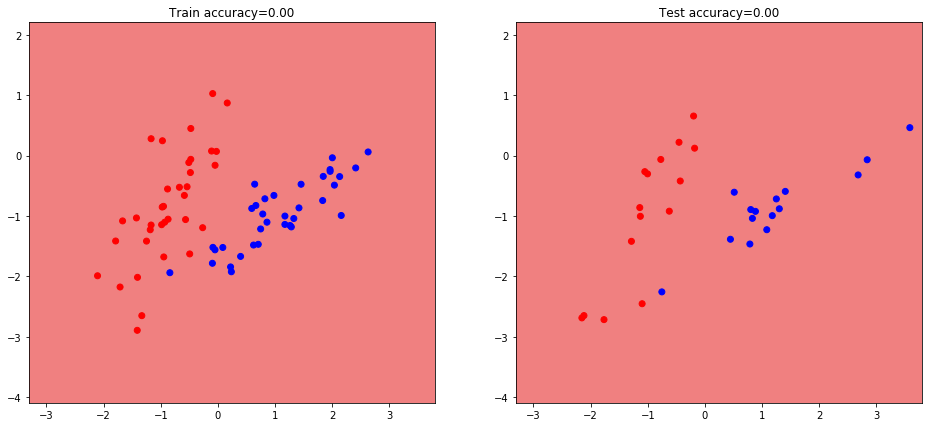

In [25]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

## Работа деревьев в случае пропущенных значений

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j}<t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз вероятности отнесения объекта $x$ к одному из классов.

Кроме этого подхода существует метод построения _суррогатных предикатов_ в каждой вершине. Проще говоря, это запасной предикат, который использует другой признак, но при этом дает максимально близкое к исходному разбиение.

## Работа деревьев с категориальными признаками

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации “нечистоты” (impurity) узла
* Предикаты для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)

### Q&A

1 - Нужно ли нормировать признаки при построении дерева решений?

__Нет, хотя результат может различаться из-за особенностей оптимизации моделей__

2 - Как повлияет на построение дерева линейное преобразование части признаков?

<img src="data/L4_Q2.png" style="width: 350px;">

3 - Может ли дерево решений для классификации, построенное без ограничения глубины, показывать качество меньше 1.0 на обучающей выборке?

<img src="data/L4_Q3.png" style="width: 300px;">

4 - Представим, что в выборке есть коррелирующие признаки. Как это отразится на построении дерева решений?

<img src="data/L4_Q4.png" style="width: 300px;">

5 - Какова сложность построения и предсказания по дереву решений?

<img src="data/L4_Q5.png" style="width: 350px;"> 

Проект: 
1. https://www.kaggle.com/c/tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/choose-tutors классификация